# NFインド株 (Nifty 50) ETF 日足

In [1]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '1678.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-09-11 00:00:00+09:00,358.000000,358.299988,353.100006,354.700012,1270960,0.0,0.0,0.0
2024-09-12 00:00:00+09:00,357.600006,359.899994,357.600006,358.799988,1626670,0.0,0.0,0.0
2024-09-13 00:00:00+09:00,360.799988,360.899994,358.000000,359.100006,964810,0.0,0.0,0.0
2024-09-17 00:00:00+09:00,360.000000,360.500000,358.200012,359.500000,899820,0.0,0.0,0.0
2024-09-18 00:00:00+09:00,362.799988,362.899994,360.799988,362.399994,1180380,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-03-05 00:00:00+09:00,313.500000,319.799988,313.299988,319.600006,1930130,0.0,0.0,0.0
2025-03-06 00:00:00+09:00,319.700012,320.500000,317.299988,318.899994,2471920,0.0,0.0,0.0
2025-03-07 00:00:00+09:00,316.899994,318.899994,315.899994,318.399994,1403590,0.0,0.0,0.0


## 日足チャートとパラボリック SAR

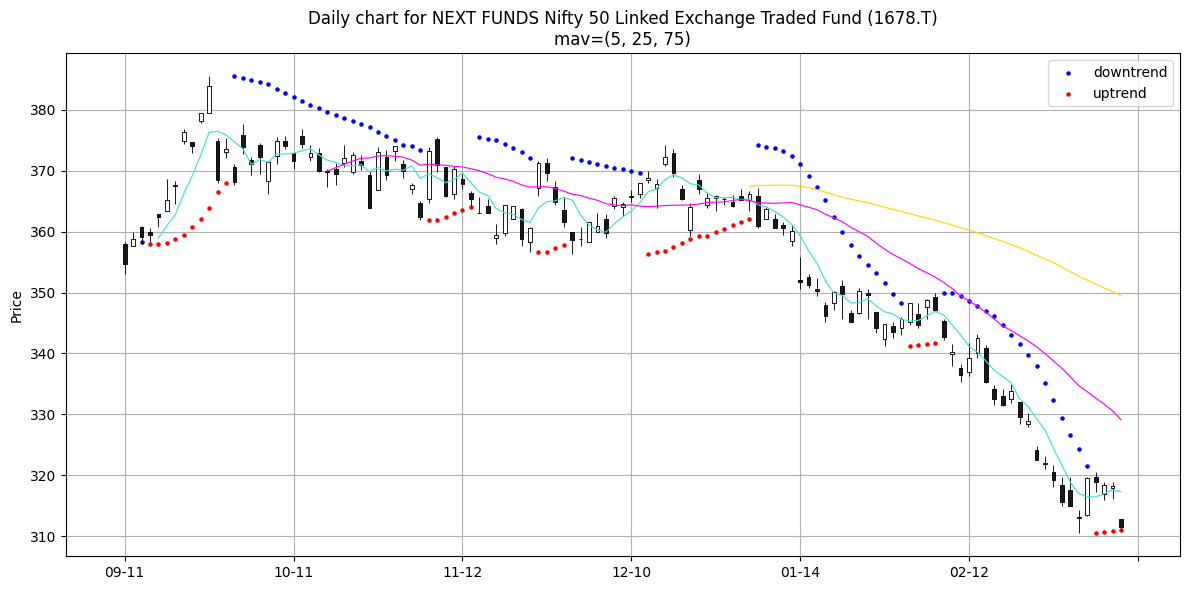

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-03-10 00:00:00+09:00    318.200012
2025-03-11 00:00:00+09:00    311.500000
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-03-10 00:00:00+09:00         NaN
2025-03-11 00:00:00+09:00   -6.700012
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-03-10 00:00:00+09:00    317.660004
2025-03-11 00:00:00+09:00    317.320001
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-03-10 00:00:00+09:00    330.592002
2025-03-11 00:00:00+09:00    329.120002
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-03-10 00:00:00+09:00    350.153334
2025-03-11 00:00:00+09:00    349.465334
Name: Close, dtype: float64